In [18]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
import loompy as lp
import warnings
import matplotlib as mpl
from copy import copy
warnings.filterwarnings("ignore")
import seaborn as sns

# R interface
#from rpy2.robjects import pandas2ri
from rpy2.robjects import r

import rpy2.rinterface_lib.callbacks
import anndata2ri
from scipy import sparse
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture as GMM

anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
adata = sc.read('Data/adata_d16_annotated.h5ad')

# Compute cluster precentages

In [3]:
# Group by 'diff_batch' and 'Cell_types' and count the number of occurrences
counts = adata.obs.groupby(['diff_batch_2', 'Cell_types']).size().reset_index(name='counts')

# Calculate the total counts per batch
totals = adata.obs.groupby('diff_batch_2').size().reset_index(name='total_counts')

# Merge the counts with the totals
counts = counts.merge(totals, on='diff_batch_2')

# Normalize the counts
counts['normalized_counts'] = counts['counts'] / counts['total_counts']

# Print the result
counts

,diff_batch_2,Cell_types,counts,total_counts,normalized_counts
0,batch-1,Optic area progenitors,168,2751,0.061069
1,batch-1,STMN2+ neurons,598,2751,0.217375
2,batch-1,Telencephalic progenitors,29,2751,0.010542
3,batch-1,Tuberal progenitors,1908,2751,0.693566
4,batch-1,Unassigned,48,2751,0.017448
5,batch-2,Optic area progenitors,7,2842,0.002463
6,batch-2,STMN2+ neurons,769,2842,0.270584
7,batch-2,Telencephalic progenitors,32,2842,0.011260
8,batch-2,Tuberal progenitors,1973,2842,0.694229
9,batch-2,Unassigned,61,2842,0.021464


[1.7 2.1 1.9]
[69.4 69.4 72.8]
[1.1 1.1 1.6]
[21.7 27.1 20. ]
[6.1 0.2 3.7]
[<matplotlib.patches.Rectangle object at 0x14b554dc9a00>, <matplotlib.patches.Rectangle object at 0x14b554d89310>, <matplotlib.patches.Rectangle object at 0x14b554d89be0>, <matplotlib.patches.Rectangle object at 0x14b554d944c0>, <matplotlib.patches.Rectangle object at 0x14b554d94d60>]


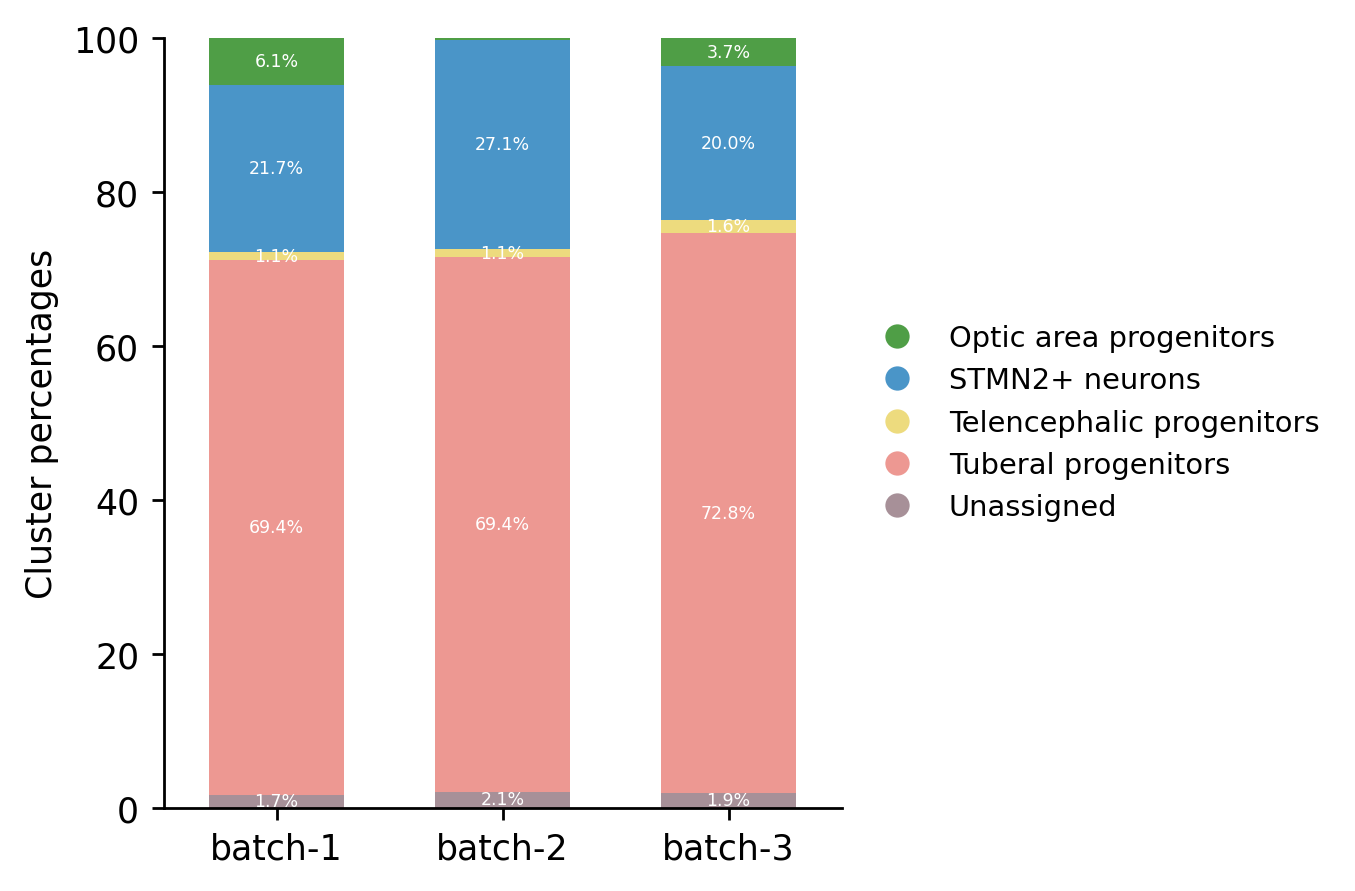

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

category_names = list(adata.obs['Cell_types'].cat.categories)

# Retrieve percentage lists for both datasets
# percentages_2D = list(adata_d50_d70[adata_d50_d70.obs.dimensionality.isin(['2D'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values)
# percentages_spheroid = list(adata_d50_d70[adata_d50_d70.obs.dimensionality.isin(['spheroid'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values)

# Create a dictionary with the percentage lists for each dataset
results = {
    'batch-1': list(adata[adata.obs.diff_batch_2.isin(['batch-1'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values),
    'batch-2': list(adata[adata.obs.diff_batch_2.isin(['batch-2'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values),
    'batch-3': list(adata[adata.obs.diff_batch_2.isin(['batch-3'])].obs['Cell_types'].value_counts(normalize=True).mul(100).round(1).sort_index(ascending=True).values)
    
}



def survey_vertical(results, category_names):
    category_names = category_names[::-1]
    labels = list(results.keys())
    data = np.array(list(results.values()))[:, ::-1]  # Ensure data is numeric
    data_cum = data.cumsum(axis=1)
    category_colors = reversed(['#4F9E46','#4a95c8','#EDDB7E','#ED9892','#a79098'])

    with plt.rc_context({ "figure.dpi": 250}):
    
        fig, ax = plt.subplots(figsize=(3.5, 4))
        ax.set_ylim(0, np.sum(data, axis=1).max())
        ax.set_xlim(-0.5, len(labels) - 0.5)

        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
            heights = data[:, i]
            starts = data_cum[:, i] - heights
            rects = ax.bar(labels, heights, bottom=starts, width=0.6,
                           label=colname, color=color)

            #r, g, b, _ = color
            #text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
            #@#labels = [f"{bar.get_height():.2f}" if bar.get_height() > 0.2 else '' for bar in bars]
            print(heights)
            percentage_labels = [f"{height}%" if height > 0.2 else '' for height in heights]
            ax.bar_label(rects, labels=percentage_labels, label_type='center', color='white', fontsize=5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        

        line1 = mlines.Line2D([], [], color="white", marker='o',label='Optic area progenitors', markersize=8, markerfacecolor='#4F9E46')
        line2 = mlines.Line2D([], [], color="white", marker='o',label='STMN2+ neurons', markersize=8, markerfacecolor='#4a95c8')
        line3 = mlines.Line2D([], [], color="white", marker='o',label='Telencephalic progenitors', markersize=8,  markerfacecolor='#EDDB7E')
        line4 = mlines.Line2D([], [], color="white", marker='o',label='Tuberal progenitors', markersize=8, markerfacecolor='#ED9892')
        line5 = mlines.Line2D([], [], color="white", marker='o',label='Unassigned', markersize=8, markerfacecolor='#a79098')
        
        
        
        #p#lt.legend((line1, line2, line3, line4), ('Thing 1', 'Thing 2', 'Thing 3', 'Thing 4')
        print(ax.patches[::len(labels)])
        ax.legend(reversed(ax.patches[::len(labels)]),ncols=1,handles=[line1, line2, line3, line4,line5],
                  loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small',frameon=False)
        ax.set_ylabel('Cluster percentages')
    #ax.set_xlabel('Questions')
    return fig, ax

survey_vertical(results, category_names)
plt.savefig('figures/cluster_percentages_d16.pdf', bbox_inches='tight')
plt.show()


## Velocity

In [ ]:
adata = sc.read('Data/adata_d16_annotated.h5ad')

In [ ]:
scv.pp.moments(adata)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata, n_jobs=1)

In [ ]:
with plt.rc_context({ "figure.dpi": 300}):
    scv.pl.velocity_embedding_stream(adata, basis='umap', color='Cell_types', legend_loc='right', save='d16_velocity.png')


# Featureplots

In [21]:
for color in ['VSX2','NR2F1']:
    with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (5.1,4) }):
        sc.pl.umap(adata, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18, save=f'd16_{color}.pdf', show=False,layer='log_transformed')
        #sc.pl.umap(adata, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18)
    

# DGE list

In [3]:
adata = sc.read('Data/adata_d16_annotated.h5ad')

In [6]:
%%R -i adata

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(edgeR)

seur <- as.Seurat(adata, counts = "counts", data = NULL)

#seur <- readRDS("Data/d50_d70_neurons_seurat.rds")
seur <- RenameAssays(seur, originalexp="RNA")

y <- Seurat2PB(seur, sample = "diff_batch_2", cluster = "Cell_types")
keep.samples <- y$samples$lib.size > 5e4
y <- y[, keep.samples]
keep.genes <- filterByExpr(y, group=y$samples$cluster)
y <- y[keep.genes, , keep=FALSE]
y <- normLibSizes(y)

cluster <- as.factor(y$samples$cluster)
#plotMDS(y, pch=16, col=c(2:16)[cluster], main="MDS")
#legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:16, cex=0.8)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

Loading required package: limma

Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘edgeR’

The following object is masked from ‘package:SingleCellExperiment’:

    cpm

Renaming default assay from originalexp to RNA
In addition: Warning message:
Cannot add objects with duplicate keys (offending key: originalexp_) setting key to original value 'rna_' 


In [7]:
%%R
batch <- factor(y$samples$sample)
design <- model.matrix(~ cluster + batch)
colnames(design) <- gsub("batch", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

  Int clusterSTMN2+ neurons clusterTelencephalic progenitors
1   1                     0                                0
2   1                     1                                0
3   1                     0                                1
4   1                     0                                0
5   1                     0                                0
6   1                     0                                0
  clusterTuberal progenitors clusterUnassigned -2 -3
1                          0                 0  0  0
2                          0                 0  0  0
3                          0                 0  0  0
4                          1                 0  0  0
5                          0                 1  0  0
6                          0                 0  1  0


In [8]:
%%R
y <- estimateDisp(y, design, robust=TRUE)
fit <- glmQLFit(y, design, robust=TRUE)

In [9]:
%%R
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

                                 clusterOptic area progenitors
Int                                                       0.00
clusterSTMN2+ neurons                                    -0.25
clusterTelencephalic progenitors                         -0.25
clusterTuberal progenitors                               -0.25
clusterUnassigned                                        -0.25
-2                                                        0.00
-3                                                        0.00
                                 clusterSTMN2+ neurons
Int                                               0.00
clusterSTMN2+ neurons                             1.00
clusterTelencephalic progenitors                 -0.25
clusterTuberal progenitors                       -0.25
clusterUnassigned                                -0.25
-2                                                0.00
-3                                                0.00
                                 clusterTelencephalic pr

In [10]:
%%R
qlf <- list()
for(i in 1:ncls){
 qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
 qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others")
}

In [11]:
%%R
top <- 200
topMarkers <- list()

de_df = data.frame(matrix( 
  vector(), 0, 7, dimnames=list(c(), c("gene","logFC","logCPM","F","PValue","FDR",'comparison'))), 
                stringsAsFactors=F)

for(i in 1:ncls) {
    #print(head(qlf[[i]])$comparison)
    ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
    up <- qlf[[i]]$table$logFC[ord] > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]]
    #genes = 
    df = as.data.frame(topTags(qlf[[i]], n='all'))
    df =df[rownames(df) %in% rownames(y)[ord[up][1:top]], ]  
    df$comparison <- head(qlf[[i]])$comparison
    de_df = rbind(de_df, df)
}
print(dim(de_df))

write.csv(de_df, "d16_arc_de_list.csv")
#topMarkers <- unique(unlist(topMarkers))
#topMarkers

[1] 1000   24


In [12]:
de_genes = pd.read_csv('d16_arc_de_list.csv',index_col=0)
de_genes['cluster'] = de_genes['comparison'].str.extract(r'cluster(.*?)_vs_others')
de_genes = de_genes[['gene','logFC','logCPM','F','PValue','FDR','comparison','cluster']]
de_genes.to_excel("d16_arc_de_list.xlsx")  
de_genes

,gene,logFC,logCPM,F,PValue,FDR,comparison,cluster
PAX2,PAX2,7.027012,3.662604,1193.069368,1.476311e-24,2.025646e-20,clusterOptic area progenitors_vs_others,Optic area progenitors
NR2F1,NR2F1,4.592788,4.610883,1076.497791,1.140437e-23,7.823968e-20,clusterOptic area progenitors_vs_others,Optic area progenitors
CDH11,CDH11,3.691478,6.861298,1365.971978,2.503188e-22,1.075472e-18,clusterOptic area progenitors_vs_others,Optic area progenitors
TRPM3,TRPM3,2.761125,7.966193,1104.169830,3.135257e-22,1.075472e-18,clusterOptic area progenitors_vs_others,Optic area progenitors
NR2F1-AS1,NR2F1-AS1,4.167954,3.943432,786.820468,4.353309e-22,1.194635e-18,clusterOptic area progenitors_vs_others,Optic area progenitors
...,...,...,...,...,...,...,...,...
S100A6,S100A6,1.212488,7.435421,158.492255,1.363461e-11,8.133932e-10,clusterUnassigned_vs_others,Unassigned
ARHGAP10,ARHGAP10,1.587492,5.158272,118.257382,1.408074e-11,8.327665e-10,clusterUnassigned_vs_others,Unassigned
OPTN,OPTN,1.530574,5.389493,115.744040,1.799384e-11,1.046159e-09,clusterUnassigned_vs_others,Unassigned
MFGE8,MFGE8,2.813435,5.779306,345.513053,1.819104e-11,1.053161e-09,clusterUnassigned_vs_others,Unassigned


In [13]:
de_dict = {}
for cluster in list(de_genes.cluster.unique()):
    de_dict[str(cluster)] = list(de_genes.groupby('cluster').get_group(cluster).gene)[0:10]
#de_dict
de_genes['cluster'].value_counts()

cluster
Optic area progenitors       200
STMN2+ neurons               200
Telencephalic progenitors    200
Tuberal progenitors          200
Unassigned                   200
Name: count, dtype: int64

In [14]:
de_dict

{'Optic area progenitors': ['PAX2',
  'NR2F1',
  'CDH11',
  'TRPM3',
  'NR2F1-AS1',
  'CLVS1',
  'ZIC1',
  'CDON',
  'FGF9',
  'FRRS1L'],
 'STMN2+ neurons': ['ELAVL4',
  'SOX2-OT',
  'SCG3',
  'KCNJ3',
  'TAGLN3',
  'STMN2',
  'RTN1',
  'ELAVL3',
  'DLL3',
  'AC068308.1'],
 'Telencephalic progenitors': ['SLC44A5',
  'AP001825.1',
  'TRPM3',
  'AP1S2',
  'FOXG1',
  'MAN1A1',
  'FSTL5',
  'SLC2A13',
  'WASF1',
  'LRFN5'],
 'Tuberal progenitors': ['KHDRBS2',
  'AC073529.1',
  'MLLT3',
  'AC002460.2',
  'CKAP2',
  'BCL2',
  'C1orf61',
  'NHS',
  'SPC25',
  'ARHGAP11B'],
 'Unassigned': ['ANKRD1',
  'S100A11',
  'KRT8',
  'S100A10',
  'ACTC1',
  'ANXA2',
  'CAVIN1',
  'CALD1',
  'SPARC',
  'ACTN1']}

In [15]:
#de_dict = {int(key):de_dict[key] for key in de_dict}
#de_dict = {key: value for key, value in sorted(de_dict.items())}
#de_dict = {str(key):de_dict[key] for key in de_dict}


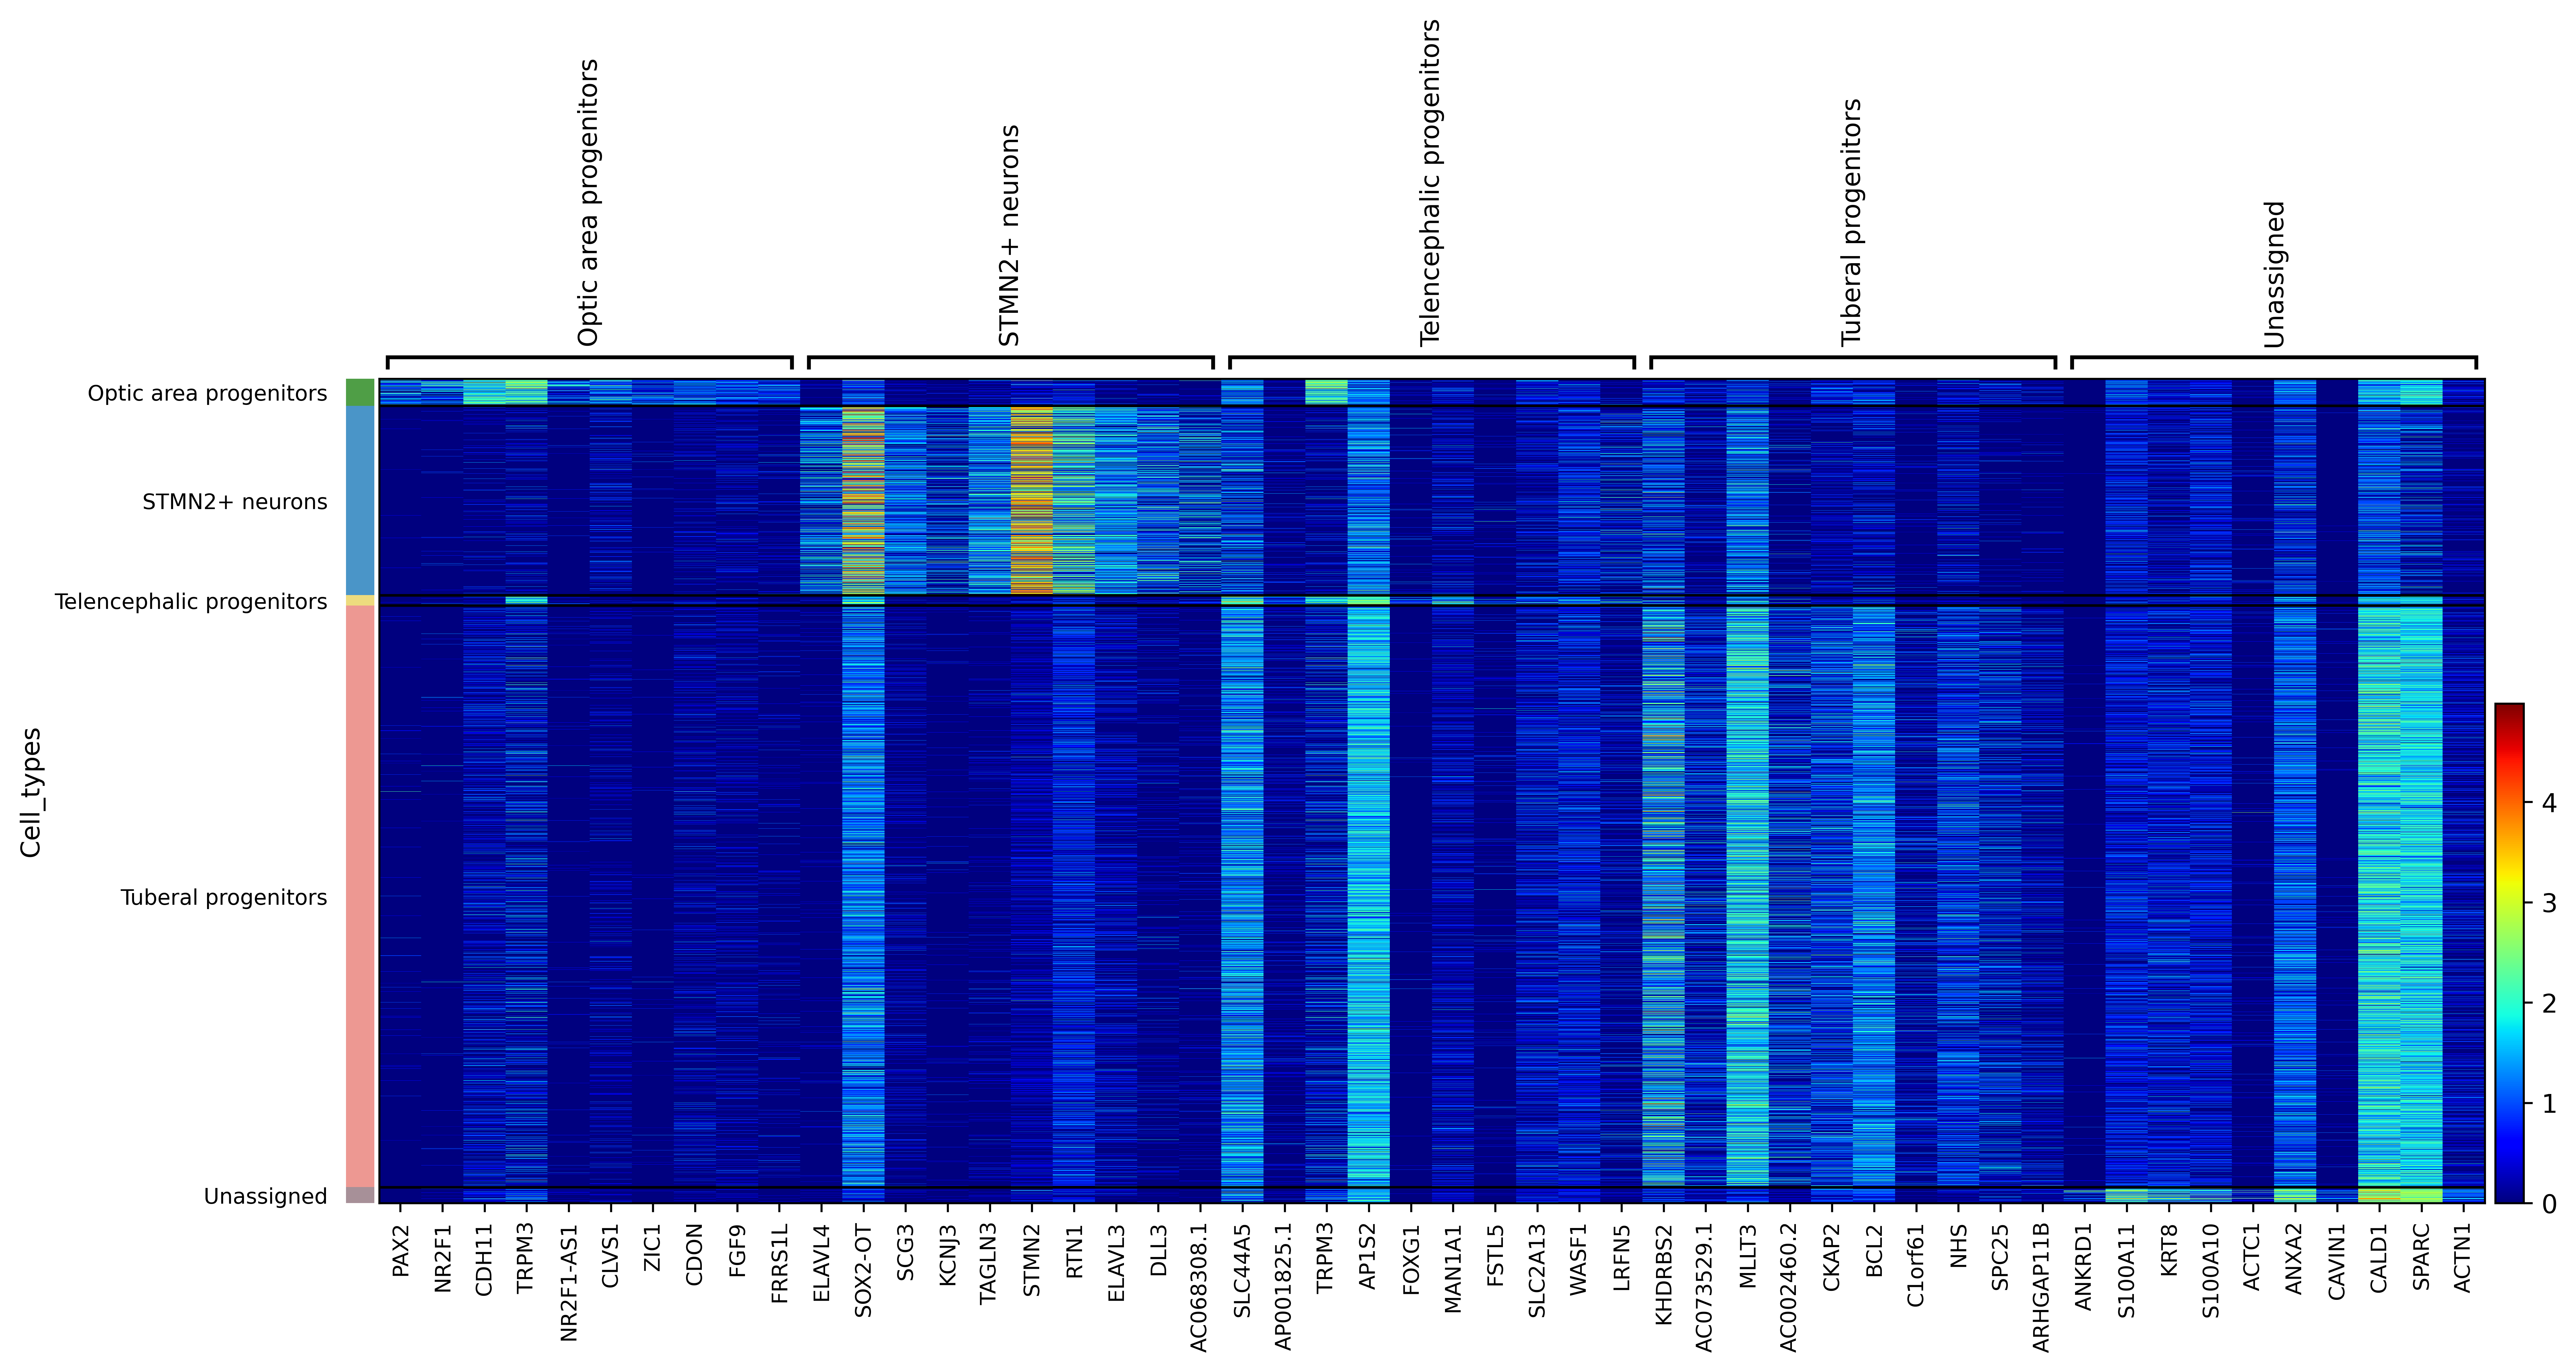

In [16]:
with plt.rc_context({ "figure.dpi": 600, "figure.figsize": (100,10)}):
    sc.pl.heatmap(adata,de_dict, groupby='Cell_types', show_gene_labels=True, layer='log_transformed', 
                        cmap='jet')